# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

**Lab made by:** Frida Svelander, \\
**In collaboration with:** Joel Kronborg

# **Abstract**

In this short report I present my solution to the lab on adaptive mesh refinement for the Stokes equations in the course DD2365/FDD3371 Advanced Computation in Fluid Mechanics at KTH Royal Institute of Technology.. I have used the FEniCS software with Python in Google Colab to solve a set of problems related to adaptive mesh refinement in 2D channel flow with a circular cylinder obstacle. 

The weak form of the Stokes equations are discretized using a finite element method, with inf-sup stable Taylor-Hood approximation spaces chosen for the trial- and test spaces. An error funcitonal based on them mean velocity, mean pressure and drag/lift force over the cylinder is introduced to indicate where the mesh should be refined. The functional is chosen as the right hand side in the weak form of the adjoint Stokes equations. The solution to the Stokes equations and the adjoint problem are used in the error functional to estimate the error in the approximate solution of the original problem.

We investigate the influence of the domain and the choice of error functional on the refined mesh. We also implement an adaptive mesh refinement algorithm that solves the Stokes equations repeatedly on the locally refined mesh until the error functional is small enough.

The report is based on a template report by Johan Hoffman.

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

We use FEniCS with Python in Google Colab to solve the Stokes equations in 2D channel flow with the finite element method. We first define the triangle mesh with resolution h=1/32 and a circular cylinder of radius 0.2 close to the inlet. The cylinder is later moved to the center of the channel and towards the outlet to investigate the effect of the placement on the adaptive mesh refinement. 

**Define domain and mesh**

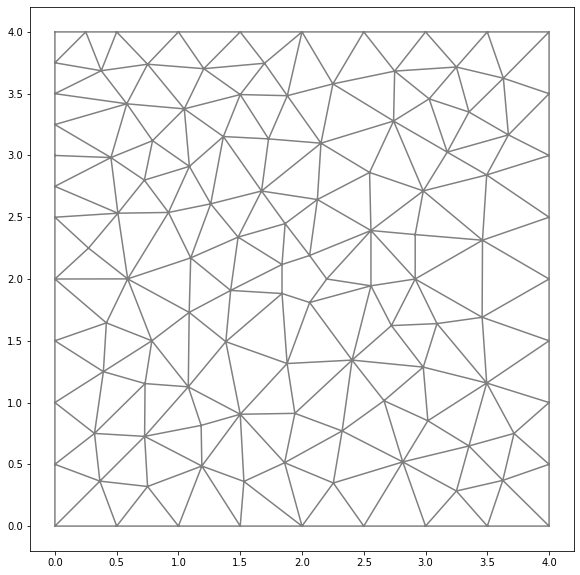

In [44]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
xc = 2.0 # 0.5 # 2.0 # 0.5 # 3.0
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 8 # 8 # 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure(figsize=(10,10))
plot(mesh)
plt.show()

**Solve adaptive finite element problem**

Next, we define the finite element approximation spaces, the variational formulation, and solve the primal and dual (adjoint) problems. The solution to the primal and dual problem (velocity $u$, pressure $p$, synthetic fields for the adjoint problem $\varphi$ and $\theta$) are fed to the error functional for each cell, and the total error is calculated by integrating over all cells in the mesh. We refine the mesh in the cells with error functional larger than the mean error over all cells, and iterate the whole procedure until the total error is smaller than $1e-3$. The cell size of the coarsest mesh is increased to $h=1/8$ to allow for more refinement where it is actually needed according to the error functional.


rm: cannot remove 'results-NS/*': No such file or directory


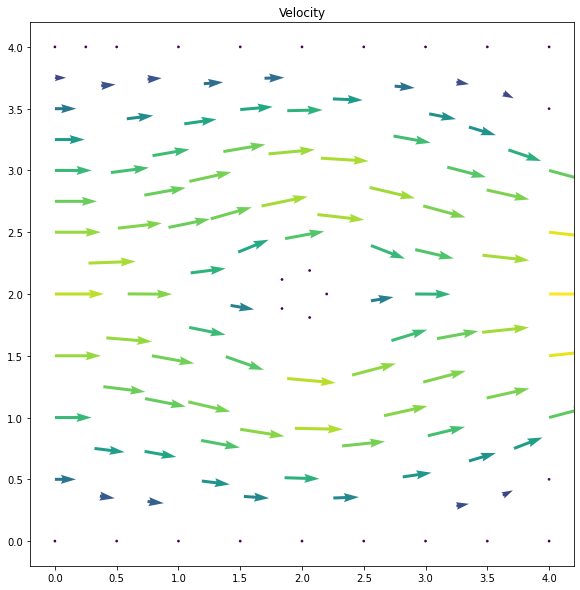

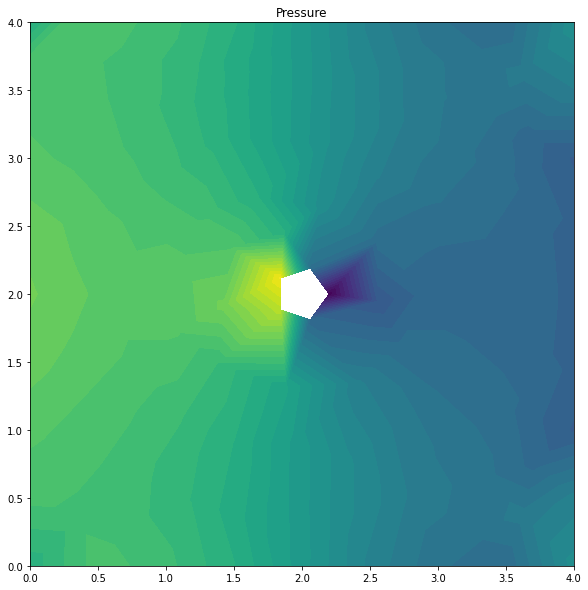

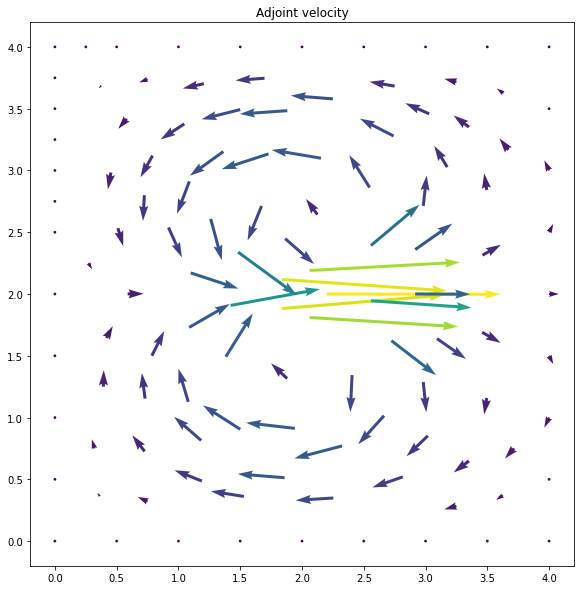

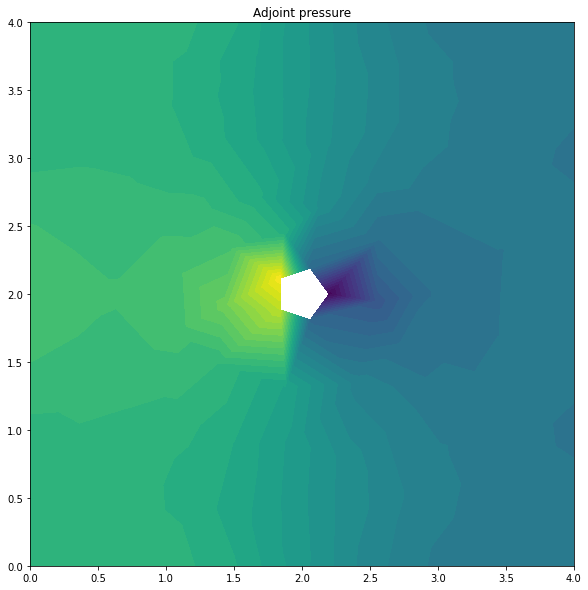

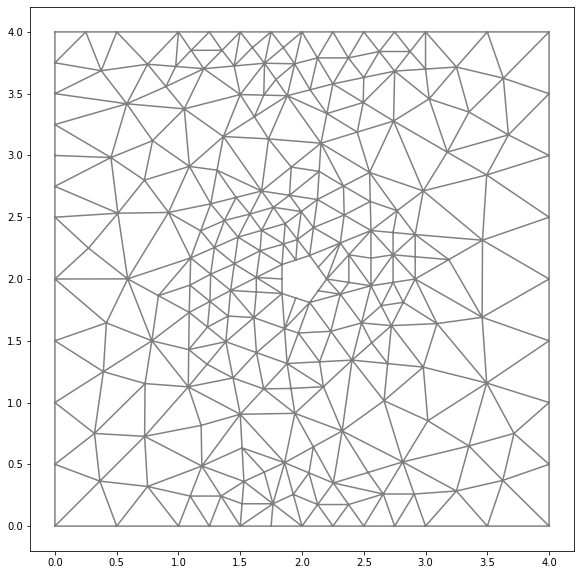

Total error = 0.016464737355588906
rm: cannot remove 'results-NS/*': No such file or directory


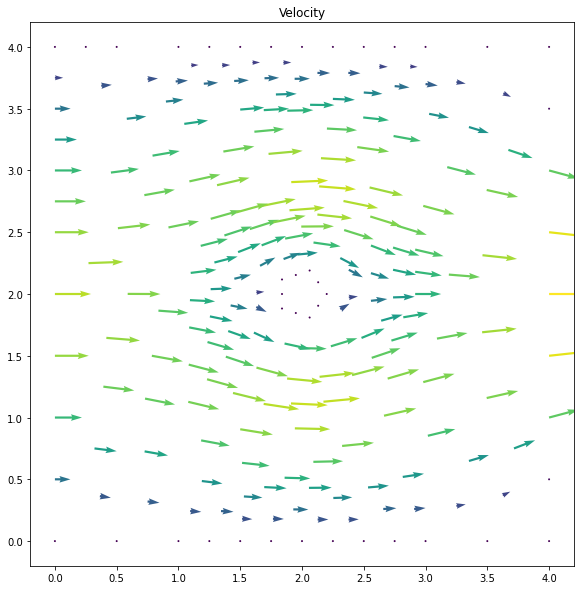

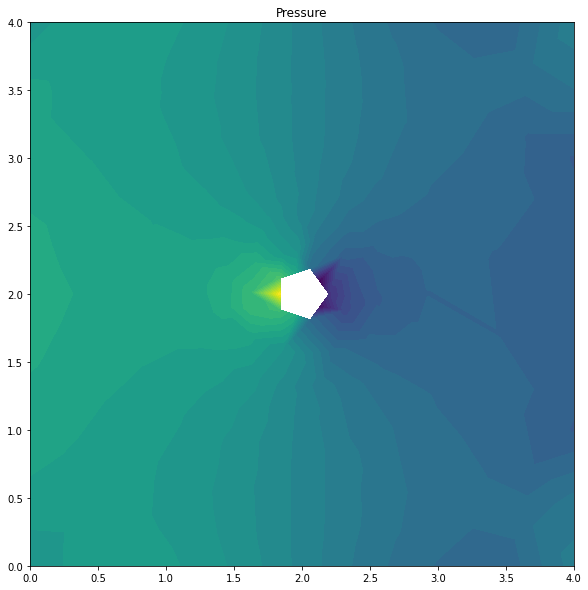

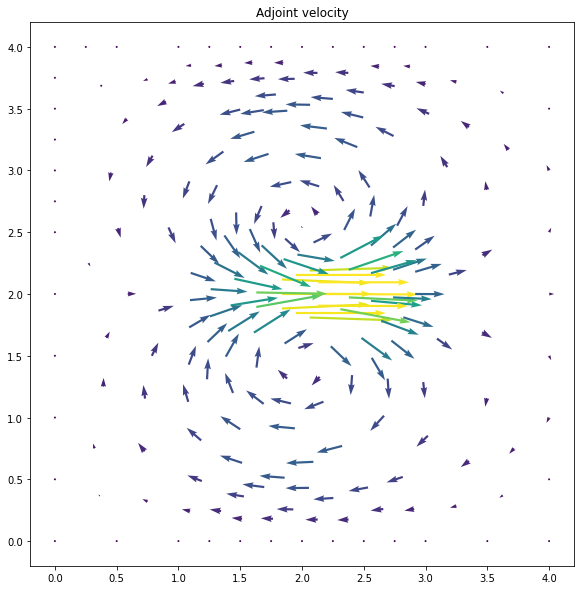

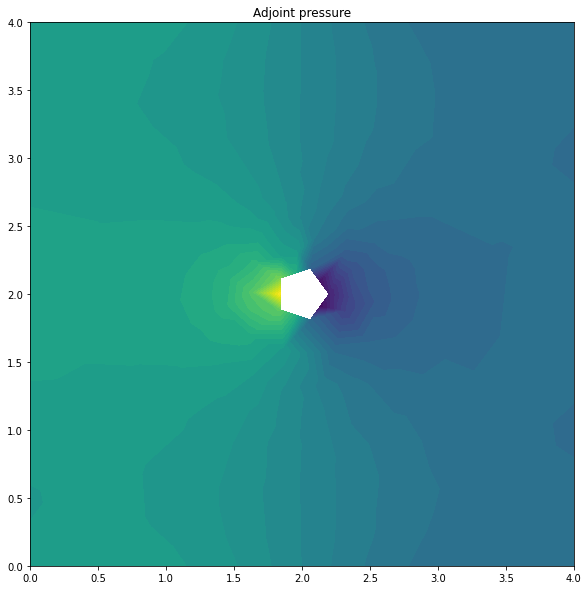

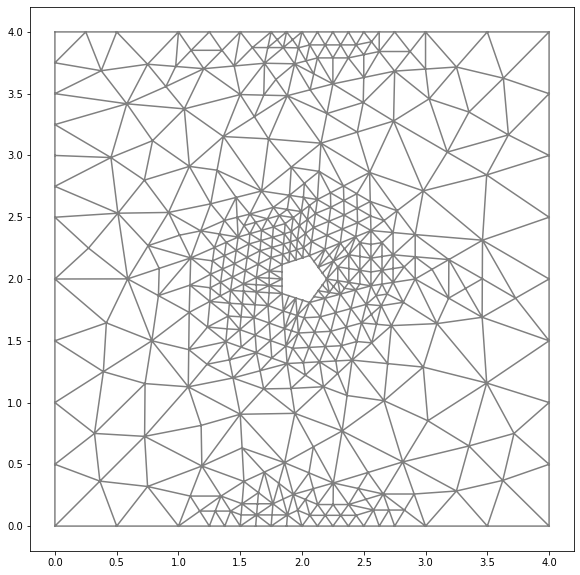

Total error = 0.021531854870168884
rm: cannot remove 'results-NS/*': No such file or directory


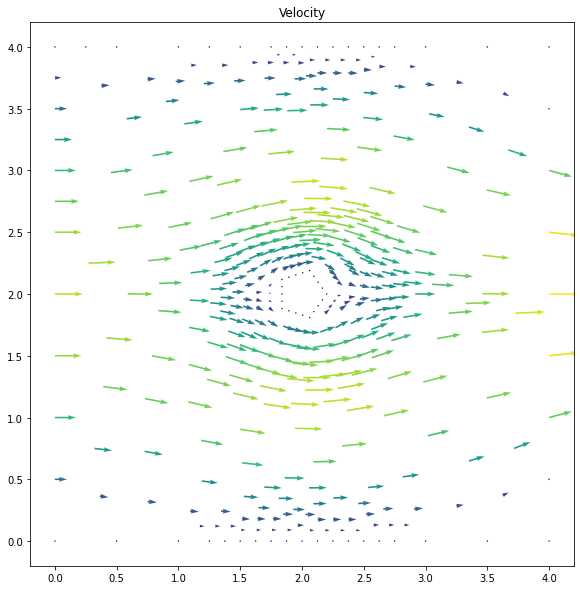

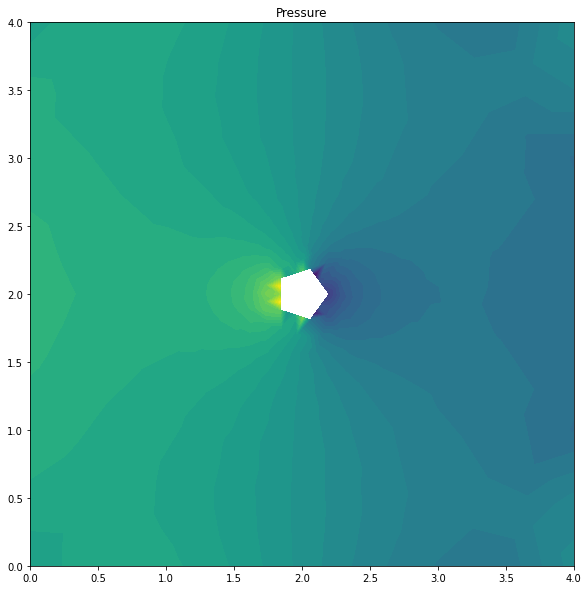

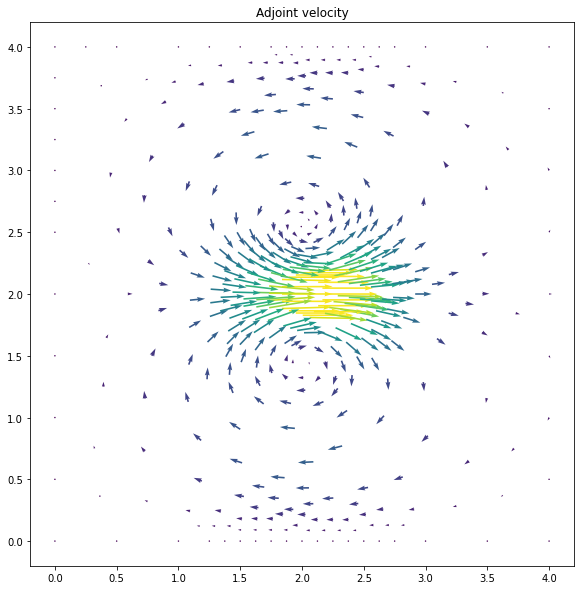

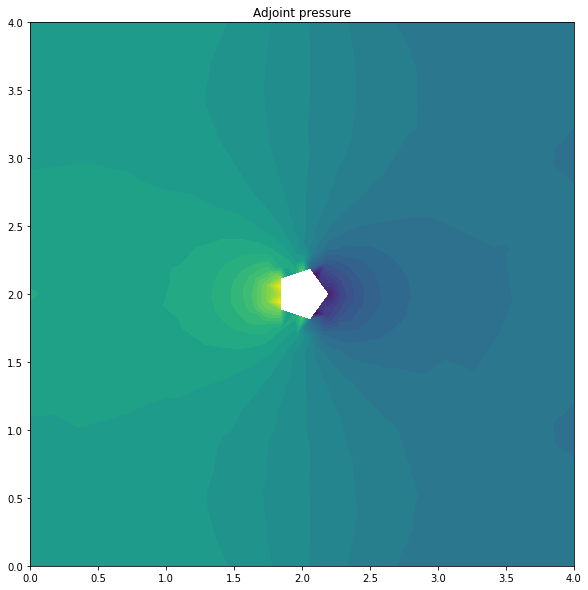

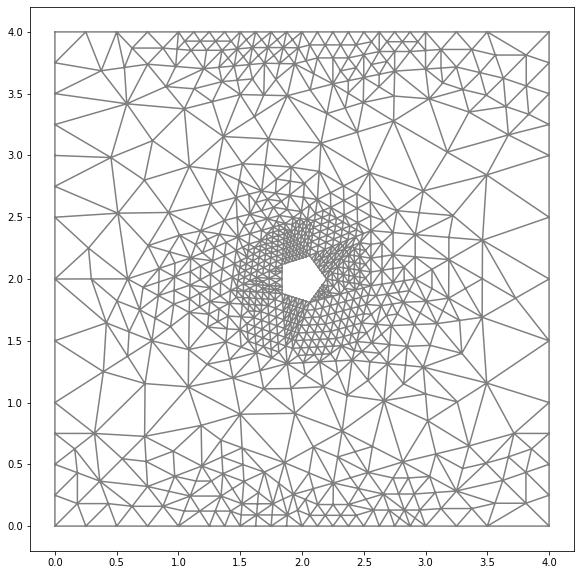

Total error = 0.003957365055154879
rm: cannot remove 'results-NS/*': No such file or directory


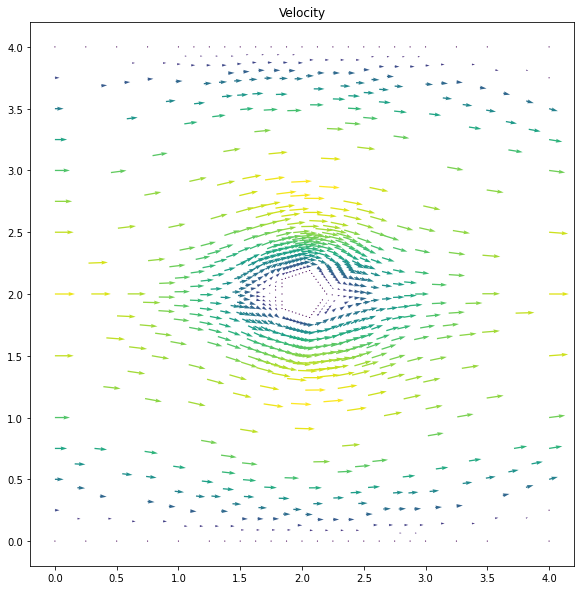

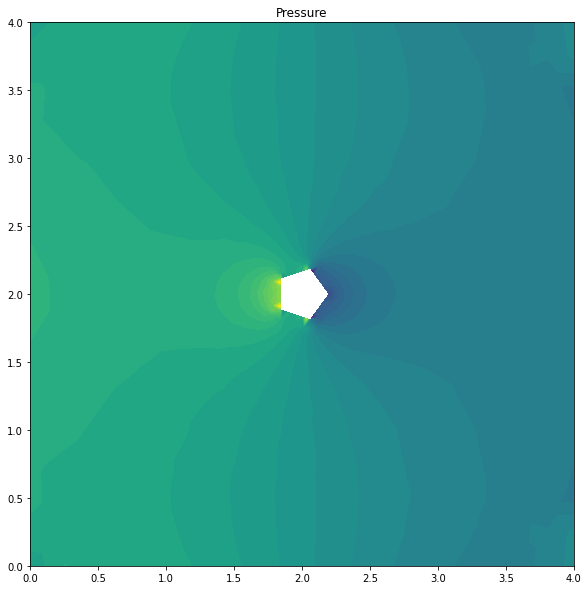

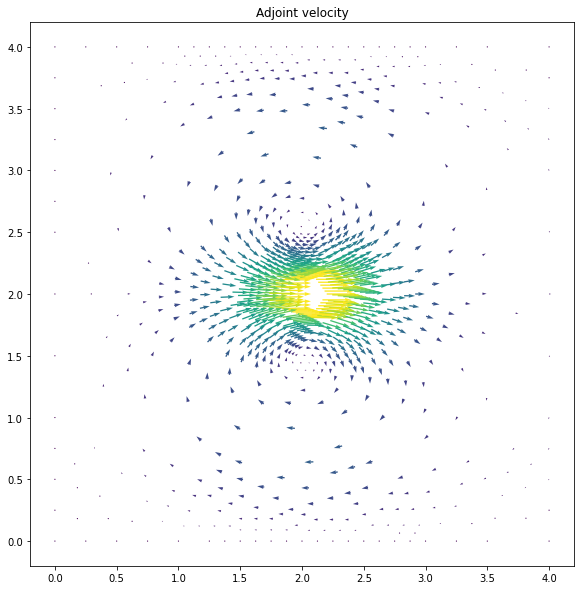

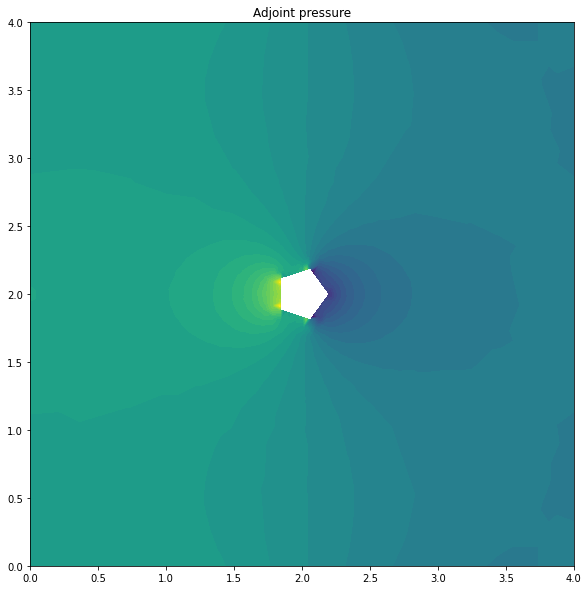

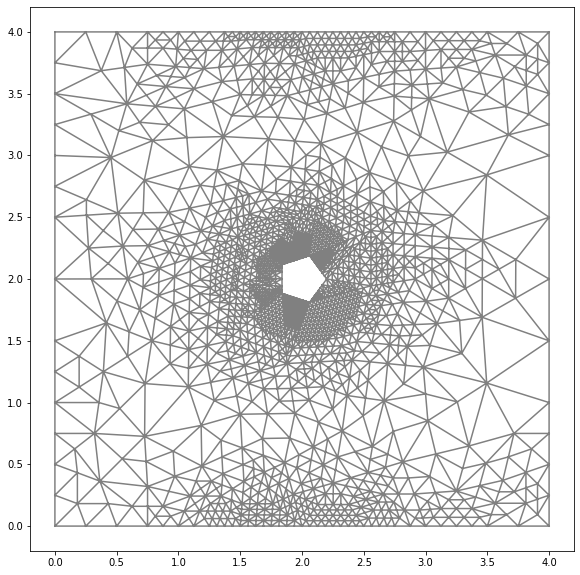

Total error = 0.0012676763625442677
rm: cannot remove 'results-NS/*': No such file or directory


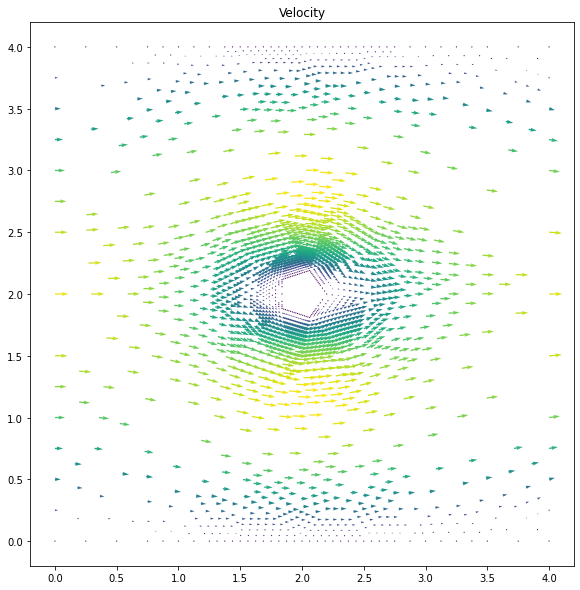

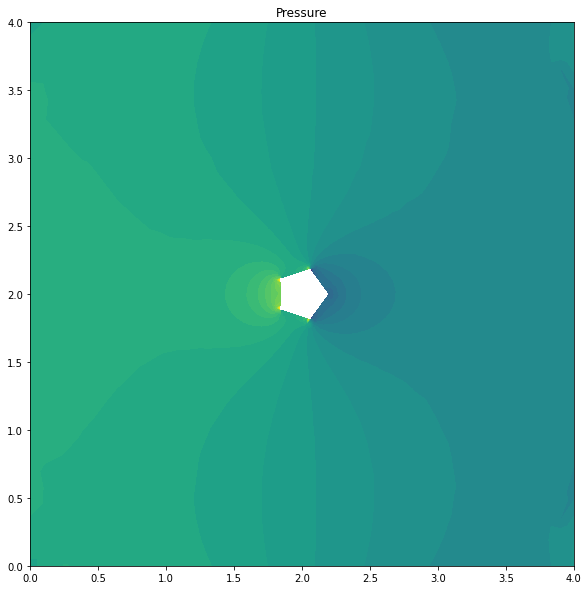

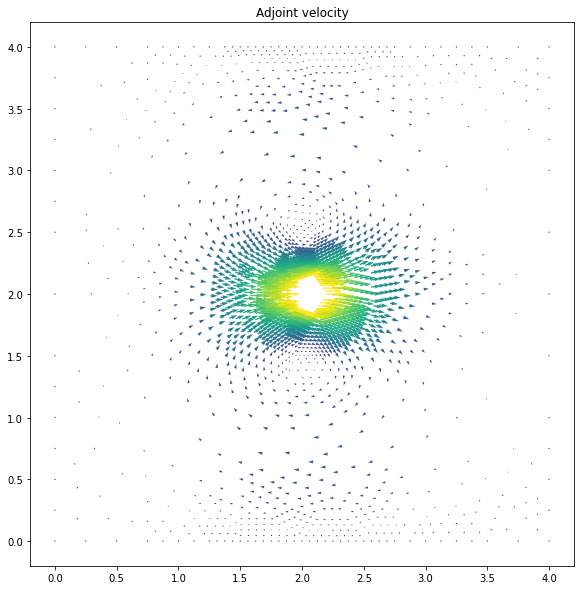

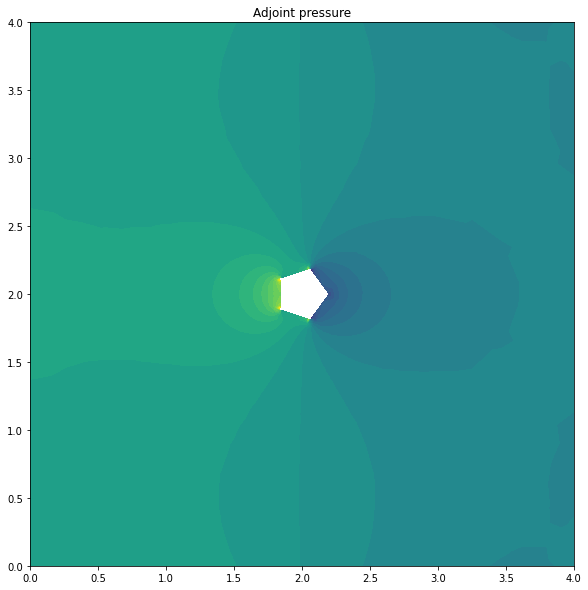

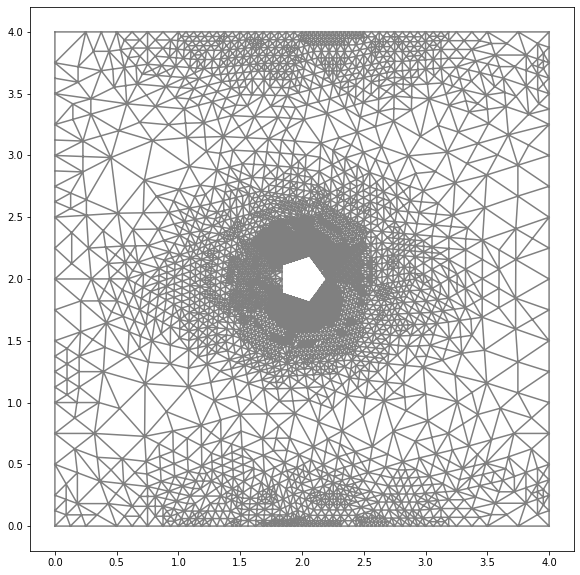

Total error = 0.0002939823170829553


In [45]:
tot_err = 1.0
tol = 1.0e-3

while tot_err > 1.0e-3:

  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

    # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
  psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
  psi2 = Expression("0.0", element = Q.ufl_element())
  phi3 = Expression(("1.0","0.0"), element = V.ufl_element())

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system 
  solve(res == 0, w) 

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system 
  solve(res_a == 0, wa) 

  !rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn

  # Plot solution
  plt.figure(figsize=(10,10))
  plot(u_fcn, title="Velocity")

  plt.figure(figsize=(10,10))
  plot(p_fcn, title="Pressure")

  plt.figure(figsize=(10,10))
  plot(phi_fcn, title="Adjoint velocity")

  plt.figure(figsize=(10,10))
  plot(theta_fcn, title="Adjoint pressure")
          
  plt.show()

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh 
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()] 
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)

  plt.figure(figsize=(10,10))
  plot(mesh)
  plt.show()

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)
  s = 'Total error = ' + repr(tot_err) 
  print(s)


# **Results**

**Mesh refinement and adjoint solution as function of cylinder placement**

We vary the placement (center) of the cylinder between $x=0.5, 2.0, 3.0$, representing a placement close to the inlet, in the center of the channel, and close to the outlet, respectively), and investigate the resulting mesh refinements when the error functional is based on the drag force. This is implemented by letting psi_1 = (0,0), psi_2 = 0 and psi_3 = (1,0).

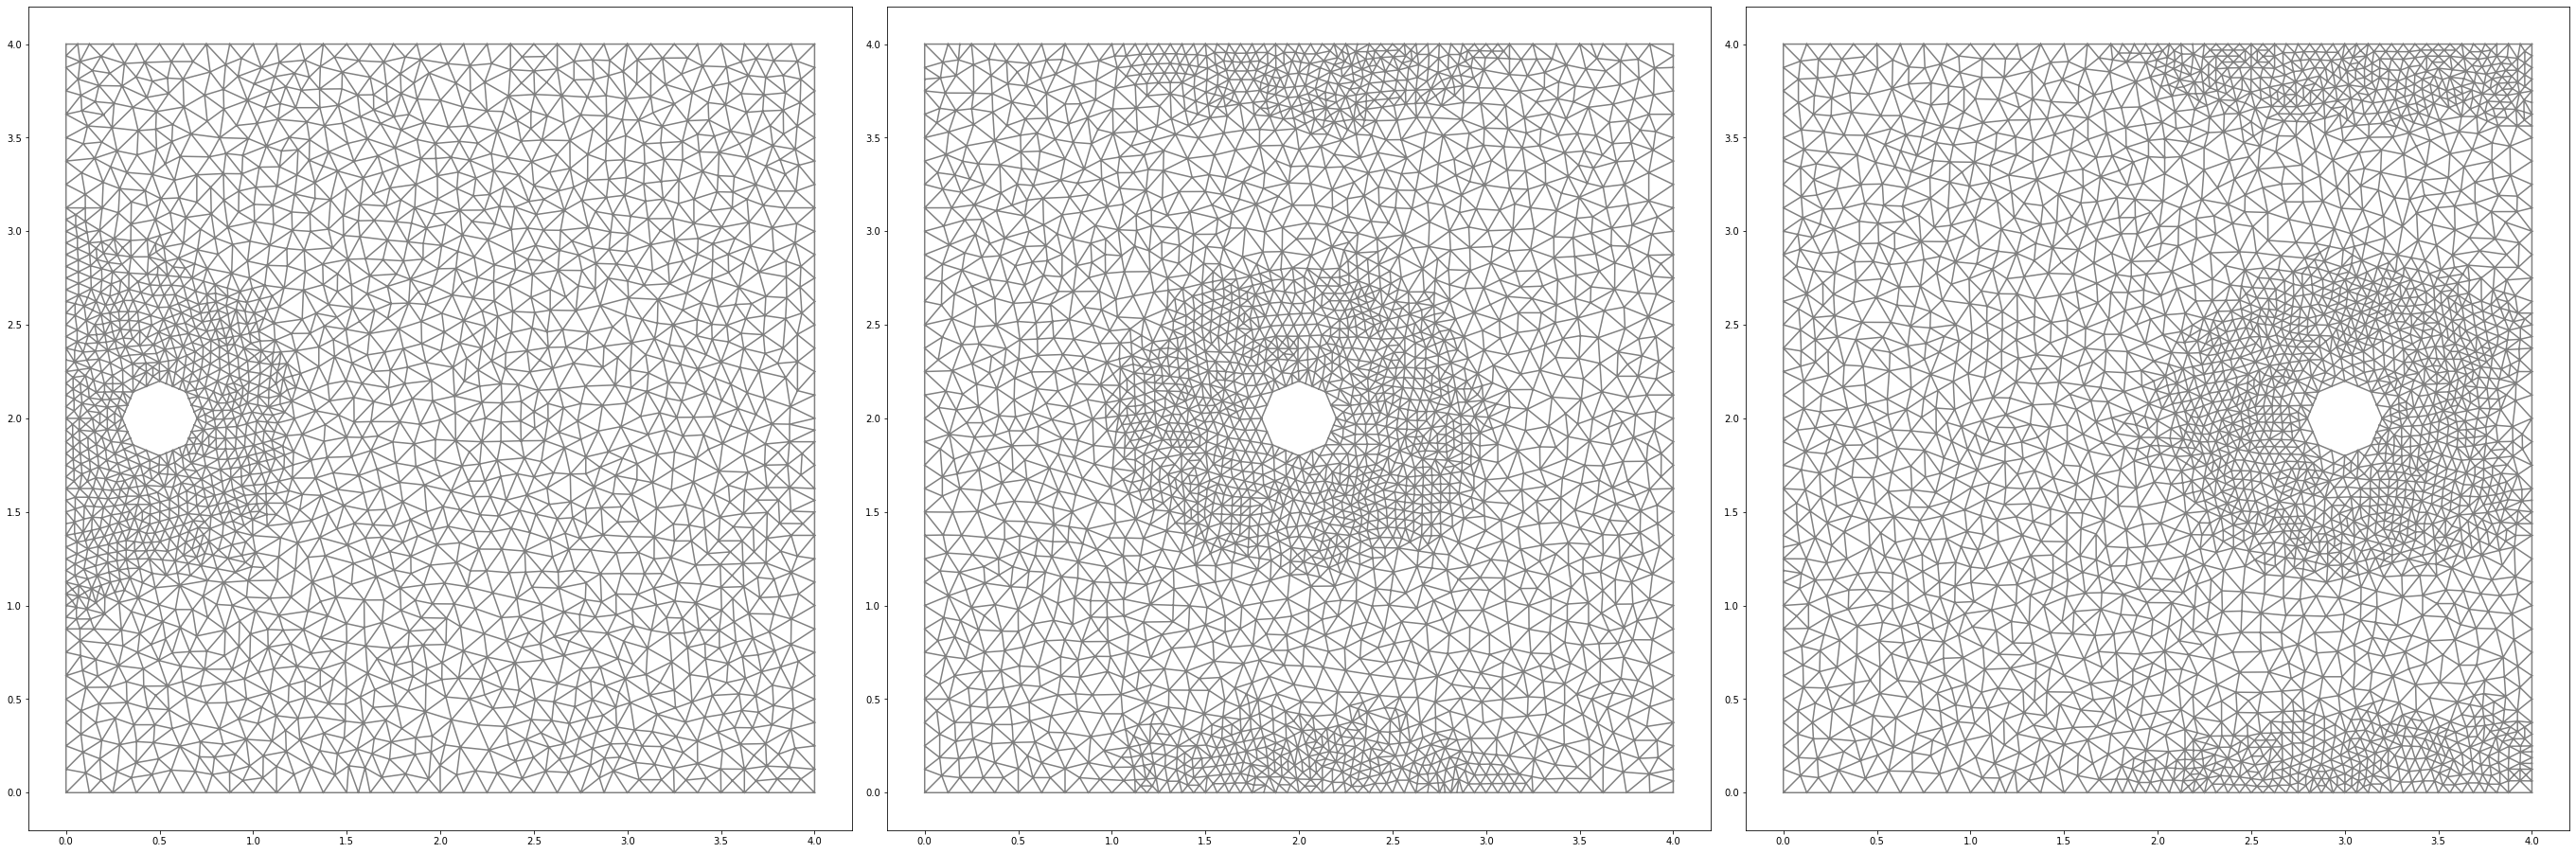
**Fig. 1.** Adaptive mesh refinement based on drag force error functional at three different locations of the circular cylinder.  

We see that when the circular cylinder is placed close to the inlet (x=0.5), the mesh is refined around the whole cylinder, but more refinement is needed at the inlet boundary. When the cylinder is placed in the center of the channel (x=2.0) and towards the outlet (x=3.0), the refinement is symmetric around the cylinder, but refinement is needed also at the top and bottom wall boundaries in the channel. This indicates that the drag force is sensible to the presence of walls, and that is logical since we choose $\Gamma_F$ (the part of the boundary where we want to compute the force) to the union of the inlet boundary (ib), the top and bottom walls (wb) and the circular body boundary (bb). See the second row of the computation of the error functional: 

In [46]:

  #err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
  #              gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

We probably do not have any effect on the top and bottom wall boundaries when the circle is placed close to the inlet since the obstacle is much closer to the inlet and the top and bottom walls are not very much affected by the obstacle. On the other hand, when the circle is located in the center of the channel, the major contributions to the drag force comes from the obstacle and the boundary layer that is generated close to the walls where the flow has to pass through in more narrow channels.

The adjoint solution $\varphi$ for the three different cases is presented in Fig. 2. We see that the pattern of $\varphi$ resembles the refined meshes in Fig. 1. 

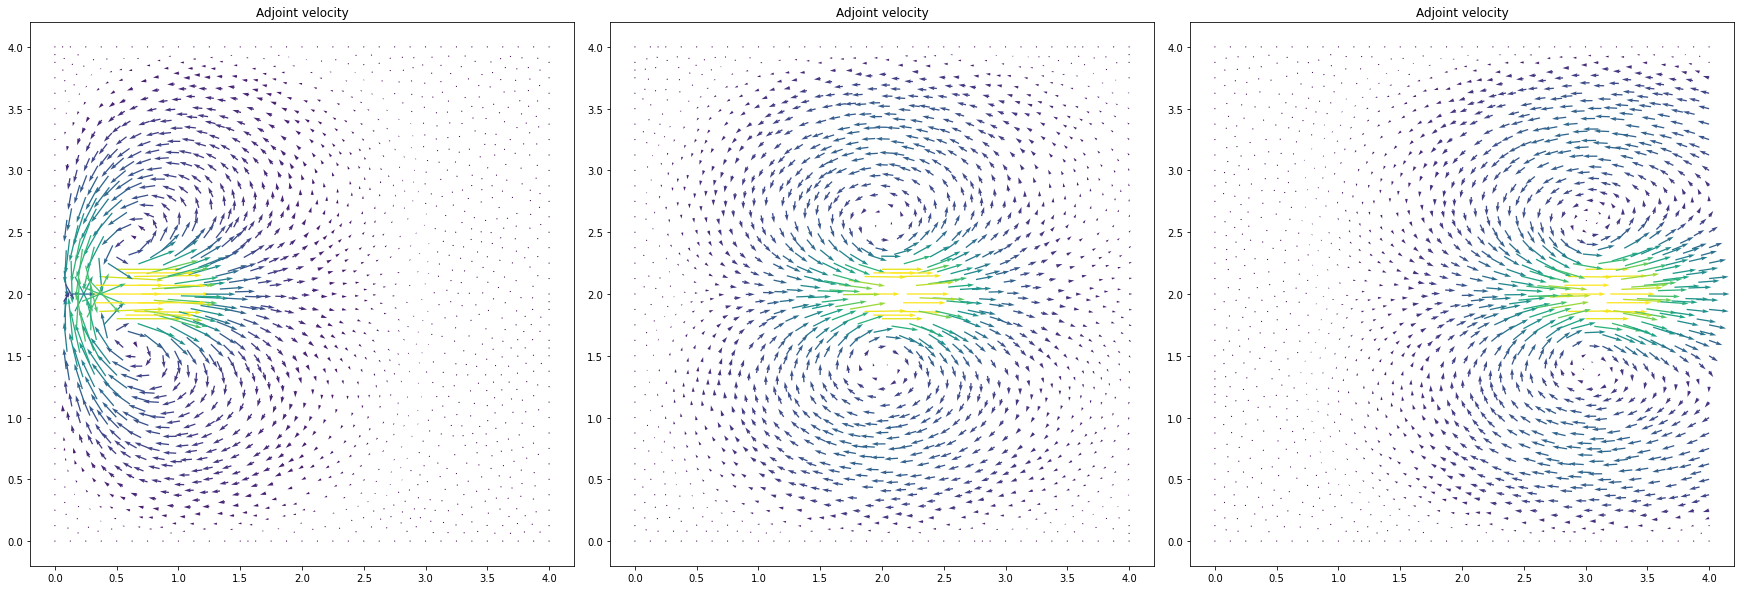
**Fig. 2.** Adjoint velocity field $\varphi$ at different placements of the circular obstacle. 


**Mesh refinement and adjoint solution as function of the error functional**

With the circle located at the center of the channel we vary the error functional $F(u, p) = (u,\psi_1)_{\Omega} + (p,\psi_2)_{\Omega} + \left<\nabla u\cdot n - pn,\psi_3 \right>_{\Gamma_F}$ and investigate the effect on the refined mesh when considering the lift force instead of the drag force $\psi_3 = (0, 1)$, the pressure $\psi_2 = 1$ and a combination of them all, $\psi_1=(1,1), \psi_2 = 1, \psi_3 = (1, 1)$. The resulting meshes are found in Fig. 3. 

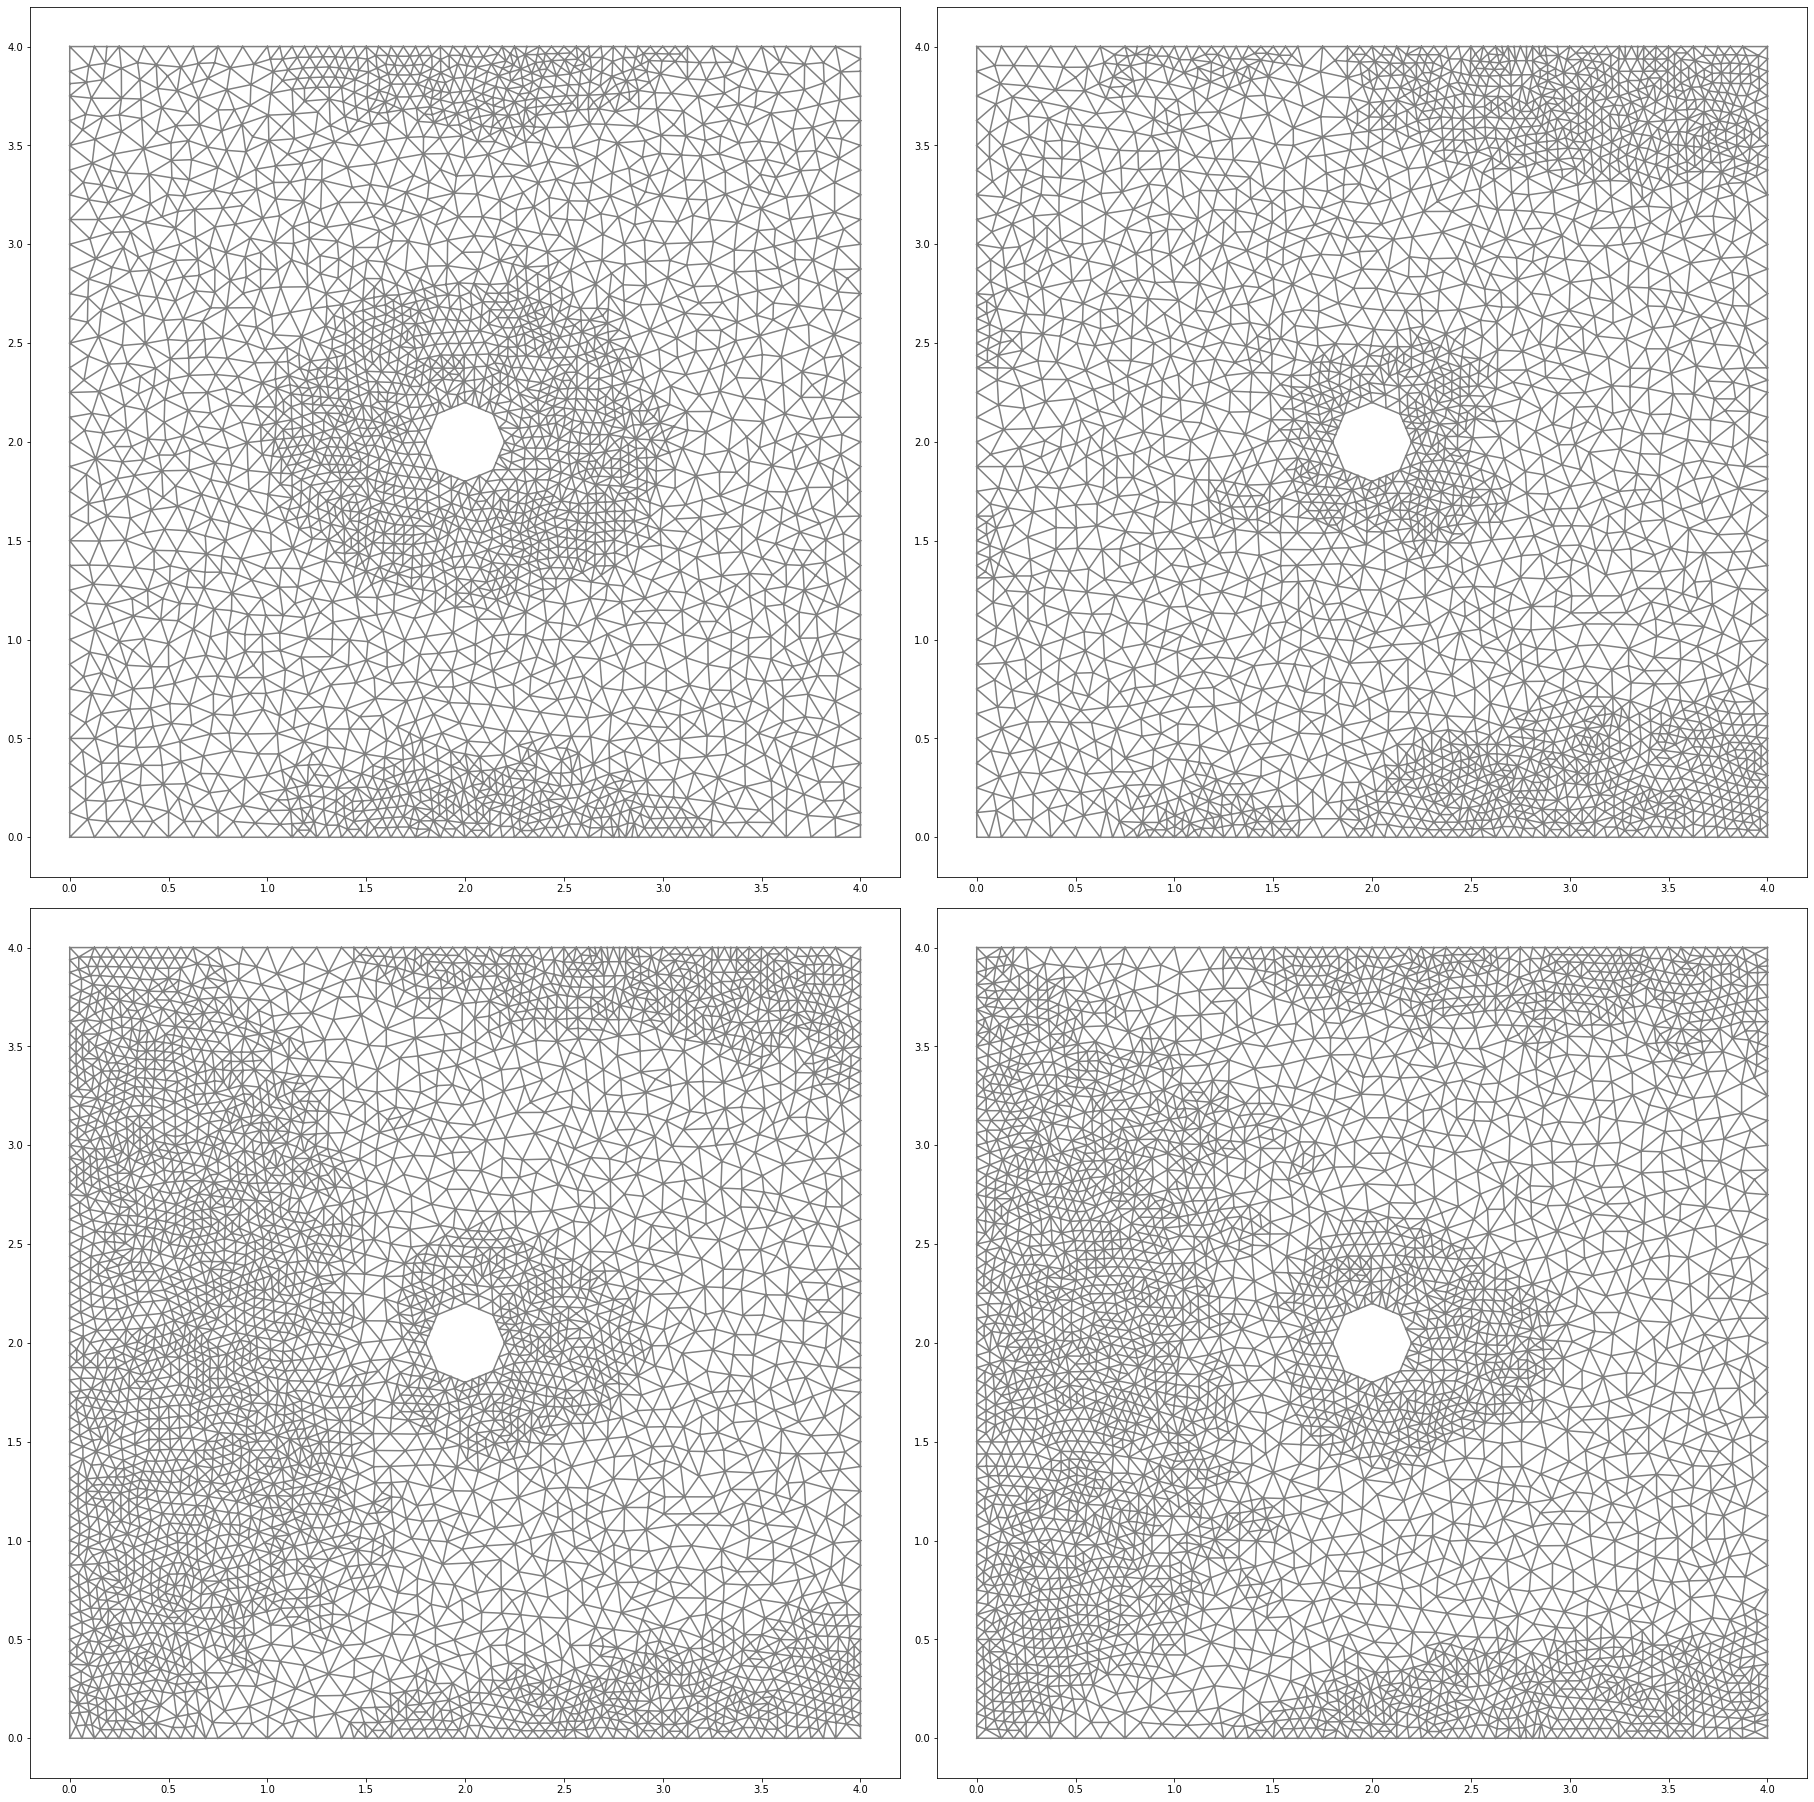
**Fig. 3.** Refined mesh with different error functionals. Drag force (top left), lift force (top right), pressure (bottom left), horisontal and vertical velocity+pressure+drag+lift (bottom right).

From the figures we see that the refinement depends a lot on the choice of error functional. Combining all three terms (velocity+pressure+force), the result is quite similar to choosing only the mean pressure as error indicator - $\psi_2=1$, $\psi_1=\psi_3=(0, 0)$. We also see that the mesh is refined mainly behind the circle in all cases except the top left one (drag force), when the refinement is quite symmetric about the center of the circle. 

**Adaptive mesh refinement**

By introducing a while loop that stops when the total error indicator is smaller than $10^{-3}$, we get an adaptive method for solution of the Stokes equations. The adaptively refined mesh at connvergence is presented along with the velocity field in Fig. 4. The error function was based on the drag force, $\psi_3=(0,1)$. The mesh was refined five times until the total error was $3.0\cdot10^{-4}$.

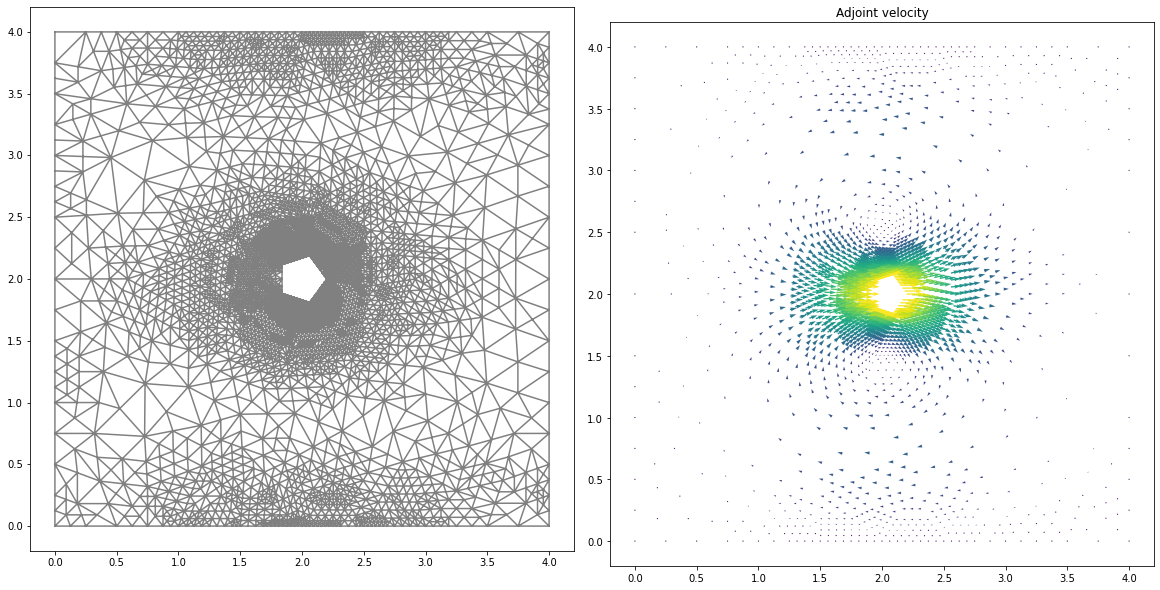
**Fig. 4.** Adaptively refined mesh with error functional based on the drag force (left). Velocity field as a solution to the Stokes problem (right). 

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh. The linear error funcitonal was varied to account for either the estimated error in the mean velocity, the mean pressure, or the drag/lift force respectively. The sum of these was also considered as an error funciton. It is obvious that the mesh refinement depends on the error funcitonal, and it seems that the mean pressure has the largest influence on the error functional. 

The domain was also altered so that the circular obstacle was placed on different places horizontally in the channel. The location of the refined cells was changed accordingly, as desired.  